# 港股个股加权流动性

用聚源数据库港股行情数据计算港股各只股票Amihud流动性，再以一定权重加权得到港股流动性指标

In [81]:
import pyodbc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 读取成分股

In [96]:
INDEX_CODE = 'HSI'

In [97]:
comp_df = pd.read_excel('../data/components/%s.xlsx'%(INDEX_CODE), index_col=0)

In [98]:
comp_df.head()

,代码,简称,收盘(元),权重（%）↓,涨跌,涨跌幅(%),指数贡献点,成交量(万股),成交额(万元),总股本(亿股),自由流通股本(亿股),总市值(亿元),自由流通市值(亿元),证监会行业,Wind行业
排名,,,,,,,,,,,,,,,
1,0002.HK,中电控股,87.10,0.0,0.00,0.00,0.0,830.19,"71,964.80",--,15.86,"2,200.54",--,NaN,公用事业
2,0003.HK,香港中华煤气,14.92,0.0,0.00,0.00,0.0,"1,828.27","27,178.53",--,89.97,"2,295.65",--,NaN,公用事业
3,0005.HK,汇丰控股,68.45,0.0,0.00,0.00,0.0,"1,606.82","110,435.78",--,175.96,"13,863.22",--,NaN,金融
4,0006.HK,电能实业,53.50,0.0,--,--,0.0,342.10,"18,292.89",--,13.05,"1,141.83",--,NaN,公用事业
5,1997.HK,九龙仓置业,51.35,0.0,0.00,0.00,0.0,234.91,"12,012.84",--,11.66,"1,559.10",--,NaN,房地产


## 逐个访问数据库并提取历史行情

In [99]:
conn = pyodbc.connect('DRIVER={SQL Server};SERVER=10.0.185.138;DATABASE=JYDB;UID=js_dev;PWD=js_dev')

In [100]:
dic = {}
for code in comp_df[u'代码']:
    jycode = '0' + code.rstrip('.HK')
    query = 'SELECT qt.TradingDay, qt.ClosePrice, qt.ChangePCT, qt.TurnoverVolume, t.SecuCode, t.SecuAbbr \
             FROM QT_HKDailyQuote as qt, HK_SecuMain as t \
             WHERE qt.InnerCode = t.InnerCode \
                AND t.SecuCode = \'%s\' \
                ORDER BY qt.TradingDay DESC'%(jycode)
    cur_df = pd.read_sql_query(query, con=conn)
    cur_df.set_index('TradingDay', inplace=True)
    dic[code] = cur_df['ChangePCT'].abs() * 1e8 / cur_df['TurnoverVolume']

In [101]:
df = pd.DataFrame(dic)

In [102]:
df = df.replace([-np.inf, np.inf], 0)

In [103]:
liquidity = df.mean(axis=1)
liquidity.to_excel('../data/liquidity/%s.xlsx'%(INDEX_CODE))

In [104]:
liquidity = liquidity[liquidity.index >= '2010-01-01']

In [105]:
liquidity.tail()

TradingDay
2018-10-05    13.811445
2018-10-08    17.374618
2018-10-09    13.252301
2018-10-10    17.237835
2018-10-11    29.279976
dtype: float64

<BarContainer object of 2163 artists>

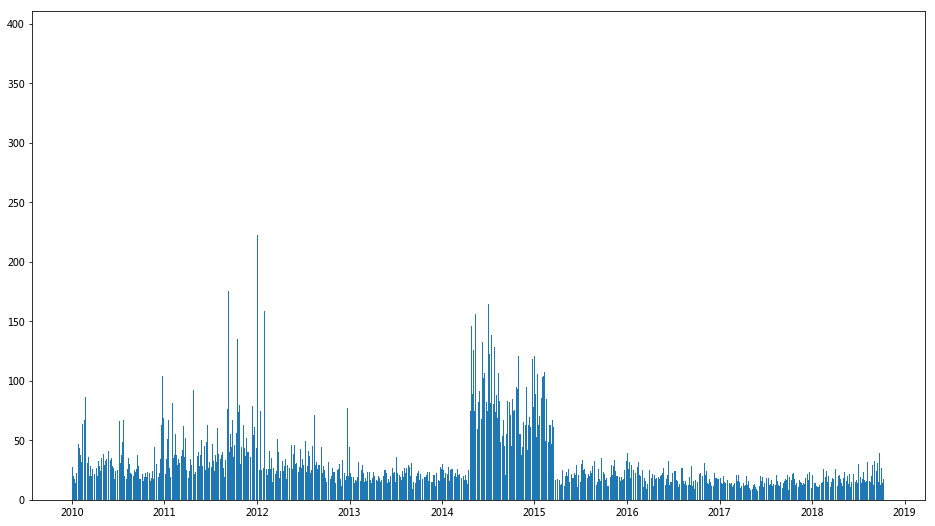

In [106]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.bar(liquidity.index, liquidity, width=2)

In [107]:
z = liquidity.rolling(243).apply(lambda x: (x[-1] - x.mean()) / x.std())

In [108]:
z[z < 2] = 0

<BarContainer object of 2163 artists>

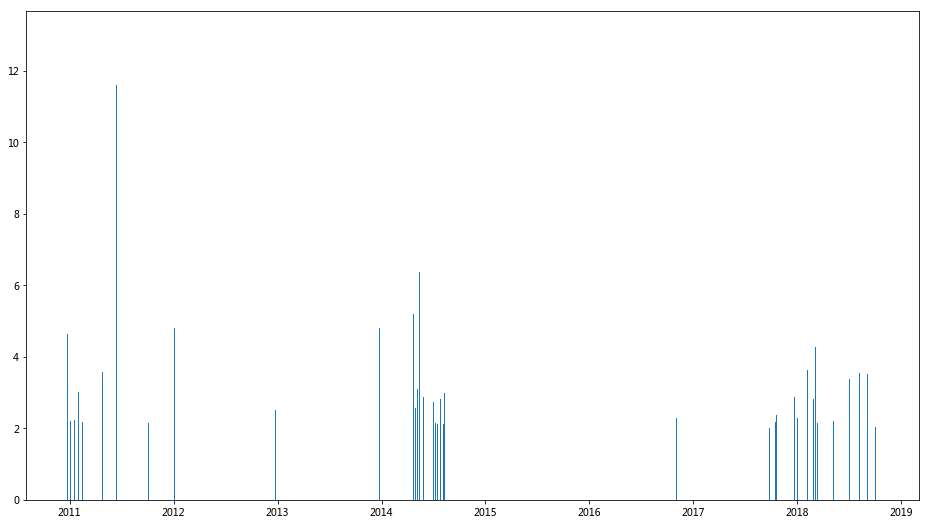

In [109]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.bar(z.index, z, width=2)